In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Model Building
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance

# Data Vis
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [7]:
df = pd.read_csv('Screen Time Data.csv', index_col='index')
df.head(5)

,Date,Week Day,Total Screen Time,Social Networking,Reading and Reference,Other,Productivity,Health and Fitness,Entertainment,Creativity,Yoga
index,,,,,,,,,,,
0,04/17/19,Wednesday,187,89,17,41,22,0,0,0,0
1,04/18/19,Thursday,123,78,17,8,9,0,0,0,0
2,04/19/19,Friday,112,52,40,8,4,0,3,0,0
3,04/20/19,Saturday,101,69,9,38,2,0,3,0,0
4,04/21/19,Sunday,56,35,2,43,3,0,1,1,0


In [8]:
df.dtypes

Date                     object
Week Day                 object
Total Screen Time         int64
Social Networking         int64
Reading and Reference     int64
Other                     int64
Productivity              int64
Health and Fitness        int64
Entertainment             int64
Creativity                int64
Yoga                      int64
dtype: object

In [9]:
# We don't need the weekday column. This can be extrapolated from the Date column. But first we need to convert it to a datetime object.
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.drop(labels=['Week Day'], axis=1, inplace=True)

In [10]:
# Create a separate DF that can be used for data vis purposes
df_num = df.iloc[:, :8].reset_index()
df_num.drop('index', axis=1, inplace=True)
df_num.head(5)

,Date,Total Screen Time,Social Networking,Reading and Reference,Other,Productivity,Health and Fitness,Entertainment
0,2019-04-17,187,89,17,41,22,0,0
1,2019-04-18,123,78,17,8,9,0,0
2,2019-04-19,112,52,40,8,4,0,3
3,2019-04-20,101,69,9,38,2,0,3
4,2019-04-21,56,35,2,43,3,0,1


In [11]:
df['weekend'] = np.where((df['Date'].dt.weekday == 5) | (df['Date'].dt.weekday == 6), 1, 0)

Question: What is the total time spent on each activity?

Answer: Total time spent on each activity vs total screen time (Note that we didn't consider the Yoga columns since it has binary values (Did yoga that day or not) not the minutes spent on doing it)


In [12]:
# Plot each value over time with a dark blue gradient indicating a weekend.
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df['Date'], y=df['weekend'],
                         fill = 'tonexty', fillcolor = 'rgba(99, 110, 250, 0.2)',
                         line_shape = 'hv', line_color = 'rgba(0,0,0,0)',
                         showlegend = False
                        ),
              row = 1, col = 1, secondary_y=True)

fig.update_xaxes(showgrid=False)#, gridwidth=1, gridcolor='rgba(0,0,255,0.1)')
fig.update_layout(yaxis2_range=[-0,0.1], yaxis2_showgrid=False,  yaxis2_tickfont_color = 'rgba(0,0,0,0)')
for x in df_num.columns[1:8]:
    fig.add_trace(go.Scatter(x=df_num['Date'], y =df_num[x].values, name=x), secondary_y = False)

fig.show()

Question: What is the correlation between total screen time and daily activities.

Answer: From the heatmap we can see that there is a strong corelation between total screen time and social networking which means the person has spent more screen time on social networking sites. Also there is a negative corelation between creativity and total screen time.

<ipython-input-13-f5f473c04783>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



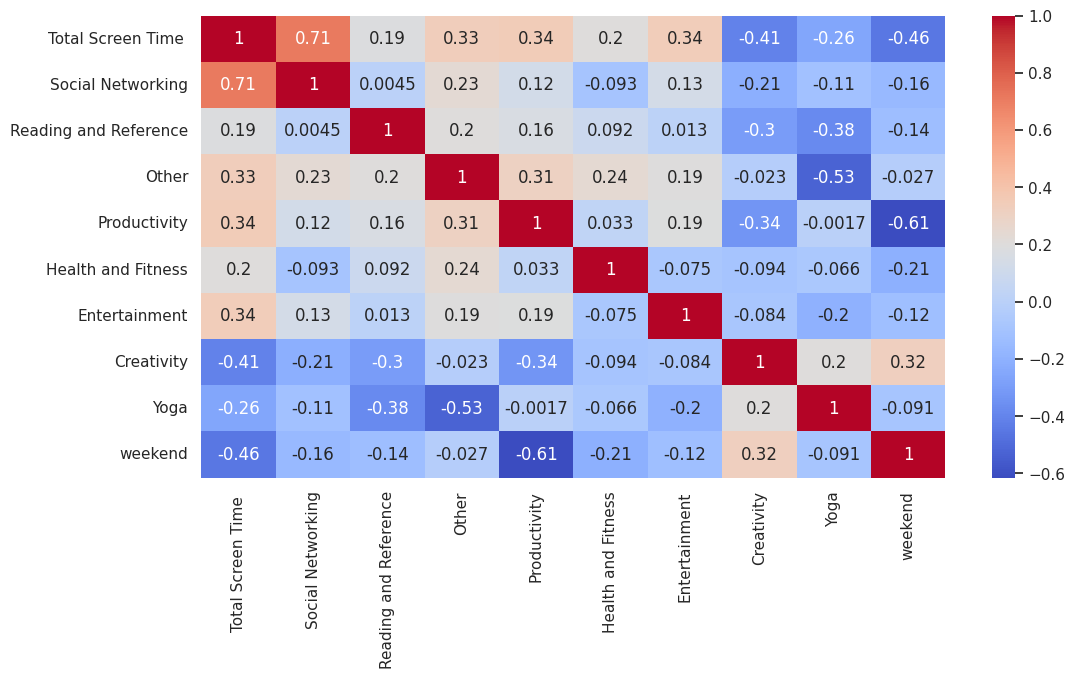

In [13]:

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")
None

Question: Do a Linear regression on the dataset.

Answer: The seaborn library is used to create histograms of the true values and linear regression model predictions in the first and second subplots, respectively. 
In the third subplot, a scatter plot with a regression line.
Linear Regression Performs very well for this task, for a dataset with low features/rows this is performing exceptionally

In [14]:
# Split our data into train/test
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df['Total Screen Time '], test_size=0.5, random_state=42)

# These will be used later for Model Comparision
names, mses, rmses, r2s = [], [], [], []

In [15]:
def display_metrics(y_test, y_preds, model_type):
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_preds)
    result = f'''
    {model_type} MSE  : {mse}
    {model_type} RMSE : {rmse} 
    {model_type} R^2  : {r2}
    '''
    
    names.append(model_type)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)
    
    print(result)

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
display_metrics(y_test, lr_preds, "Linear Regression")


    Linear Regression MSE  : 1.7562297638520354e-27
    Linear Regression RMSE : 4.190739509742923e-14 
    Linear Regression R^2  : 1.0
    


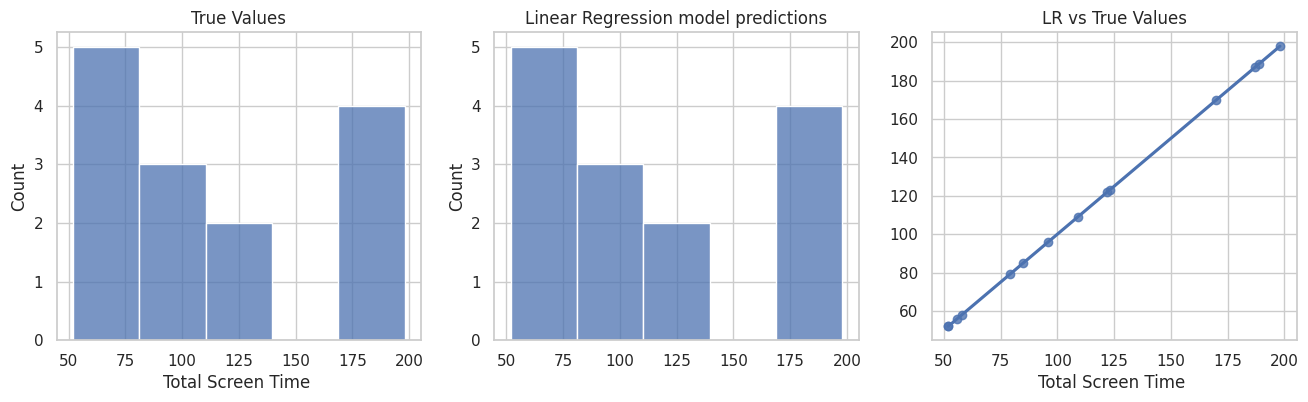

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

sns.histplot(y_test, ax=axes[0])
sns.histplot(lr_preds, ax=axes[1])
sns.regplot(x=y_test, y=lr_preds, ax=axes[2])

axes[0].set_title('True Values')
axes[1].set_title('Linear Regression model predictions')
axes[2].set_title('LR vs True Values')
None

Question: Perform a t-test to determine the statistical significance of the relationship.

Answer: The t-statistic is a measure of the difference between the means of the two samples, while the p-value represents the probability of obtaining a t-value as extreme or more extreme than the observed value, assuming the null hypothesis that there is no difference between the means of the two samples.

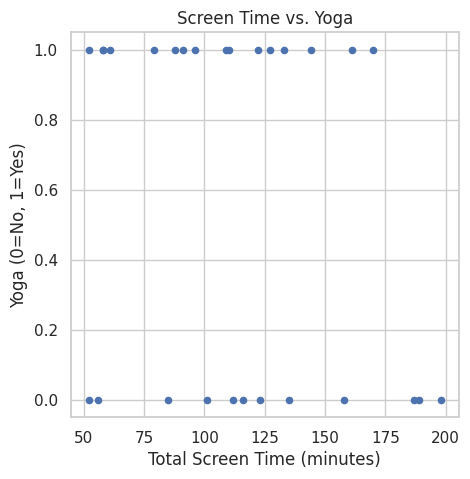

t-statistic: 13.686, p-value: 0.000


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a scatter plot of the data
df.plot(kind='scatter', x='Total Screen Time ', y='Yoga', figsize=(5,5))

# Add a title and axis labels
plt.title('Screen Time vs. Yoga')
plt.xlabel('Total Screen Time (minutes)')
plt.ylabel('Yoga (0=No, 1=Yes)')

# Show the plot
plt.show()

# Perform a t-test to determine the statistical significance of the relationship
t, p = stats.ttest_ind(df['Total Screen Time '], df['Yoga'])
print(f't-statistic: {t:.3f}, p-value: {p:.3f}')

Question: Investigate how long it takes to establish a healthy habit, such as decreased phone usage, by looking at changes in average daily screen time over the period of a month or two months before and after beginning yoga practice, adjusting for weekly period effect.

Answer: There's a drop of about 20 minutes in the average total screen time. We can now confirm an increase in the social netowrking percentage of the daily screen time Notice how the blue part of each bar dominates the bars in the after yoga compared to the before yoga graph.


In [21]:
yoga_mask = df['Yoga'] == 1
pre_yoga = df[~yoga_mask]
post_yoga = df[yoga_mask]

details_columns = df.columns[4:-1]
details_columns
     

Index(['Other', 'Productivity', 'Health and Fitness', 'Entertainment',
       'Creativity', 'Yoga'],
      dtype='object')

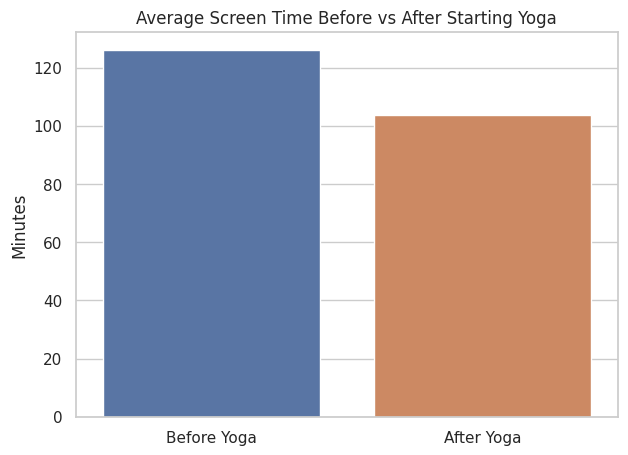

In [22]:
plt.figure(figsize=(7, 5))
sns.barplot(x=['Before Yoga', 'After Yoga'], 
            y=[pre_yoga['Total Screen Time '].mean(), post_yoga['Total Screen Time '].mean()])

plt.ylabel("Minutes")
plt.title("Average Screen Time Before vs After Starting Yoga")
plt.show()

AttributeError: ignored

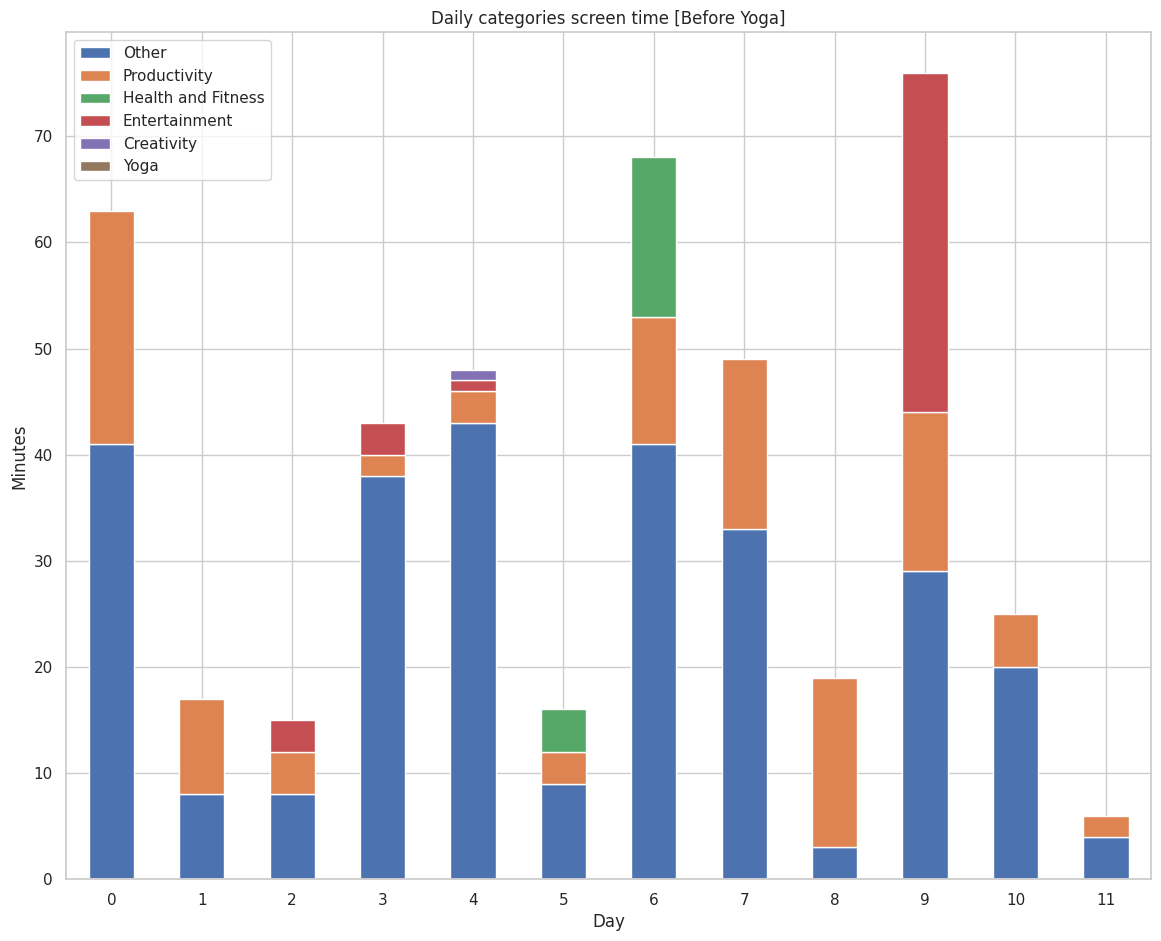

In [23]:
ax = pre_yoga[details_columns].plot(kind='bar', stacked=True,figsize=(14,11),
                                title = "Daily categories screen time [Before Yoga]",
                                xlabel="Day",
                                ylabel= "Minutes",
                                rot=0)
plt.xticks(range(pre_yoga.shape[0]),labels=pre_yoga['Date'].str[:5])
plt.show()

AttributeError: ignored

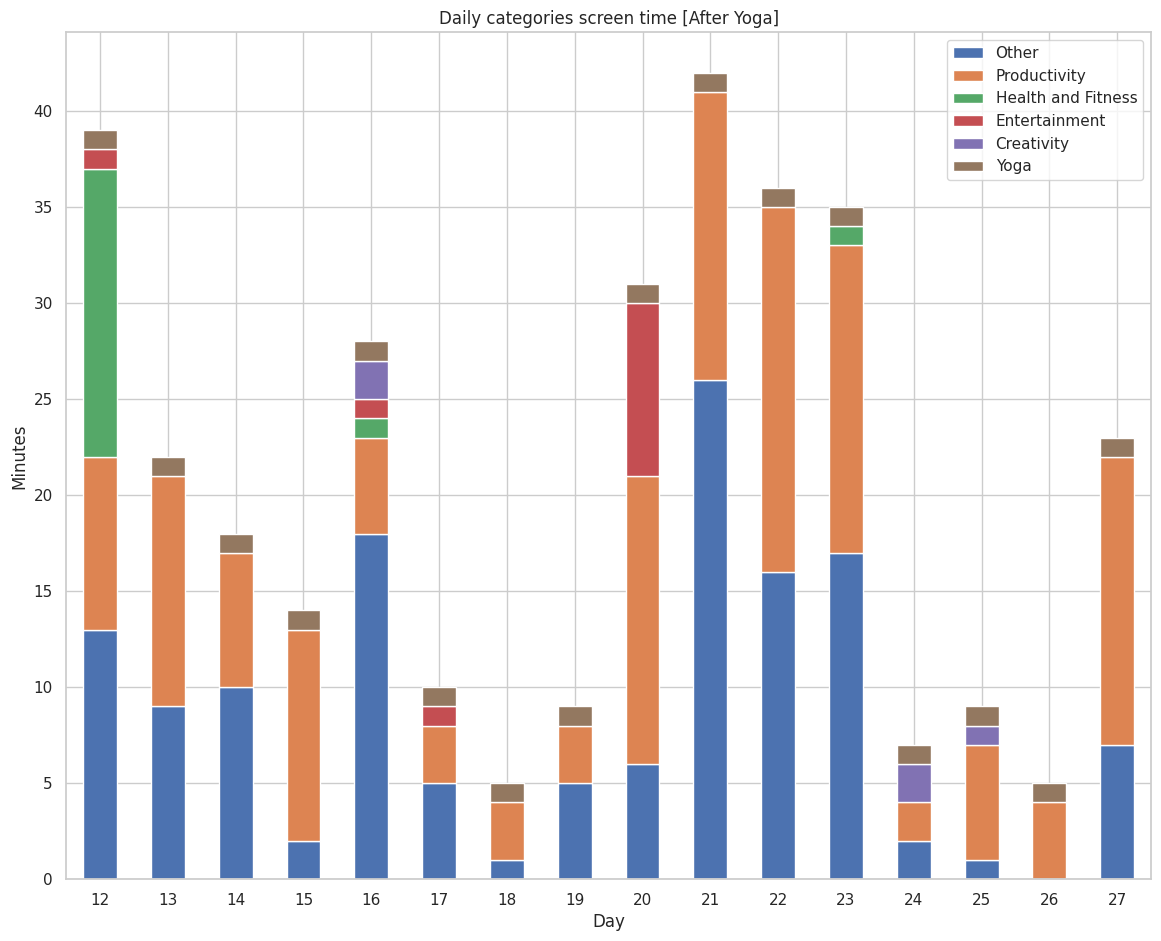

In [24]:
ax = post_yoga[details_columns].plot(kind='bar', stacked=True,figsize=(14,11),
                                title = "Daily categories screen time [After Yoga]",
                                xlabel="Day",
                                ylabel= "Minutes",
                                rot=0)
plt.xticks(range(post_yoga.shape[0]),labels=post_yoga['Date'].str[:5])
plt.show()


Question: The median value for screen time spent on social networking sites for people who do yoga and who do not.

Answer: The median value for screen time spent on social networking sites for people who do yoga is less than the median value for people who do not do yoga. So if the person does Yoga, the time spent on social networking decreases. From the box plot we can infer that the screen time was less when the person did yoga as compared to the screen time when the person did not do yoga.

In [25]:
px.box(df, y='Social Networking', color= 'Yoga',width=800,height=400)

In [26]:
px.box(df, y='Total Screen Time ', color= 'Yoga',width=800,height=400)